In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score



In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [12]:
batch_path = lambda n: os.path.join("data",f"batch{n}.pkl")

batch1 = pickle.load(open(batch_path(1), 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

FileNotFoundError: [Errno 2] No such file or directory: 'data/batch1.pkl'

In [16]:
os.listdir(".")

['Load Data_update.ipynb',
 'BuildPkl_Batch3.ipynb',
 'BuildPkl_Batch1.ipynb',
 'batch1pkl.py',
 'BuildPkl_Batch2.ipynb']

In [4]:
numBat1 = len(batch1.keys())
numBat1

41

In [5]:
batch2 = pickle.load(open(r'.\Data\batch2.pkl','rb'))

In [6]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [7]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [8]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [9]:
numBat2 = len(batch2.keys())
numBat2

43

In [10]:
batch3 = pickle.load(open(r'.\Data\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [11]:
numBat3 = len(batch3.keys())
numBat3

40

In [12]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [13]:
bat_dict = {**batch1, **batch2, **batch3}

Text(0, 0.5, 'Discharge Capacity (Ah)')

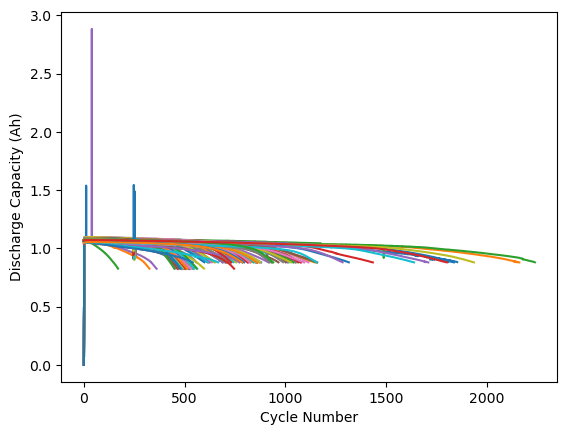

In [14]:
for i in bat_dict.keys():
    plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

### Train and Test Split
If you are interested in using the same train/test split as the paper, use the indices specified below

In [15]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [16]:
test_ind

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

#### Exploring the dataset for battery B1C0



In [17]:
"""
batch entry structure (for refernce):

batch1['b1c0']
│
├── cycle_life: NumPy array
│       [1852.]
│
├── charge_policy: String
│       "3.6C(80%)-3.6C"
│
├── summary: Dictionary
│   ├── IR: NumPy array (Internal Resistance over cycles)
│   ├── QC: NumPy array (Charge Capacity over cycles)
│   ├── QD: NumPy array (Discharge Capacity over cycles)
│   ├── Tavg: NumPy array (Average Temperature over cycles)
│   ├── Tmin: NumPy array (Minimum Temperature over cycles)
│   ├── Tmax: NumPy array (Maximum Temperature over cycles)
│   ├── chargetime: NumPy array (Charging time over cycles)
│   └── cycle: NumPy array (Cycle numbers)
│
└── cycles: Dictionary (Detailed per-cycle data)
    ├── '0': Dictionary
    │   ├── I: NumPy array (Current data)
    │   ├── Qc: NumPy array (Charge capacity data)
    │   ├── Qd: NumPy array (Discharge capacity data)
    │   ├── Qdlin: NumPy array (Linearized discharge capacity)
    │   ├── T: NumPy array (Temperature data)
    │   ├── Tdlin: NumPy array (Linearized temperature)
    │   ├── V: NumPy array (Voltage data)
    │   ├── dQdV: NumPy array (differential capacity vs. voltage)
    │   └── t: NumPy array (Time data)
    │
    ├── '1': Dictionary
    │   ├── I: NumPy array (Current data)
    │   ├── Qc: NumPy array (Charge capacity data)
    │   ├── Qd: NumPy array (Discharge capacity data)
    │   ├── Qdlin: NumPy array (Linearized discharge capacity)
    │   ├── T: NumPy array (Temperature data)
    │   ├── Tdlin: NumPy array (Linearized temperature)
    │   ├── V: NumPy array (Voltage data)
    │   ├── dQdV: NumPy array (differential capacity vs. voltage)
    │   └── t: NumPy array (Time data)
    │
    └── ... : Additional cycles ('2', '3', ..., '1851')
    """


'\nbatch entry structure (for refernce):\n\nbatch1[\'b1c0\']\n│\n├── cycle_life: NumPy array\n│       [1852.]\n│\n├── charge_policy: String\n│       "3.6C(80%)-3.6C"\n│\n├── summary: Dictionary\n│   ├── IR: NumPy array (Internal Resistance over cycles)\n│   ├── QC: NumPy array (Charge Capacity over cycles)\n│   ├── QD: NumPy array (Discharge Capacity over cycles)\n│   ├── Tavg: NumPy array (Average Temperature over cycles)\n│   ├── Tmin: NumPy array (Minimum Temperature over cycles)\n│   ├── Tmax: NumPy array (Maximum Temperature over cycles)\n│   ├── chargetime: NumPy array (Charging time over cycles)\n│   └── cycle: NumPy array (Cycle numbers)\n│\n└── cycles: Dictionary (Detailed per-cycle data)\n    ├── \'0\': Dictionary\n    │   ├── I: NumPy array (Current data)\n    │   ├── Qc: NumPy array (Charge capacity data)\n    │   ├── Qd: NumPy array (Discharge capacity data)\n    │   ├── Qdlin: NumPy array (Linearized discharge capacity)\n    │   ├── T: NumPy array (Temperature data)\n    

In [18]:
batch1['b1c0'].keys()

dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])

In [19]:
print(batch1['b1c0']['cycle_life'])
print(batch1['b1c0']['charge_policy'])
print(batch1['b1c0']['summary'].keys())
print(batch1['b1c0']['cycles'].keys())

print(len(batch1['b1c0']['summary']['IR']))
print(len(batch1['b1c0']['cycles'].keys()))

"""
For B1C0, all the 1851 cycles have a trends recorded for all the attributed (Ir, Qc, ..) and
Summary stores all the max values corresponding to those cycles (Just one max value for the 
entire trend)

"""

[[1852.]]
3.6C(80%)-3.6C
dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '14

'\nFor B1C0, all the 1851 cycles have a trends recorded for all the attributed (Ir, Qc, ..) and\nSummary stores all the max values corresponding to those cycles (Just one max value for the \nentire trend)\n\n'

In [20]:
print(batch1['b1c0']['cycles']['1500'].keys())

print(batch1['b1c0']['summary']['QC'][1500])
print(batch1['b1c0']['cycles']['1500']['Qc'].max())

"""
See I told yaa !

"""

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])
0.97060257
0.97060257


'\nSee I told yaa !\n\n'

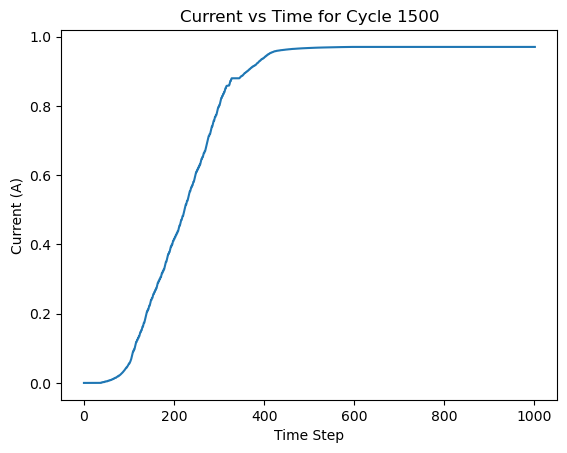

In [21]:
x = batch1['b1c0']['cycles']['1500']['Qc']
plt.plot(np.arange(len(x)), x)
plt.xlabel('Time Step')
plt.ylabel('Current (A)')
plt.title('Current vs Time for Cycle 1500')
plt.show()

In [22]:
# For Battery b1c0
b1c0_summary_df = pd.DataFrame(batch1['b1c0']['summary'])
features = pd.DataFrame(batch1['b1c0']['summary']).iloc[:, 0:-1]
target = pd.DataFrame(batch1['b1c0']['summary']).iloc[:,-1]
features.head()

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442


<Figure size 1000x800 with 0 Axes>

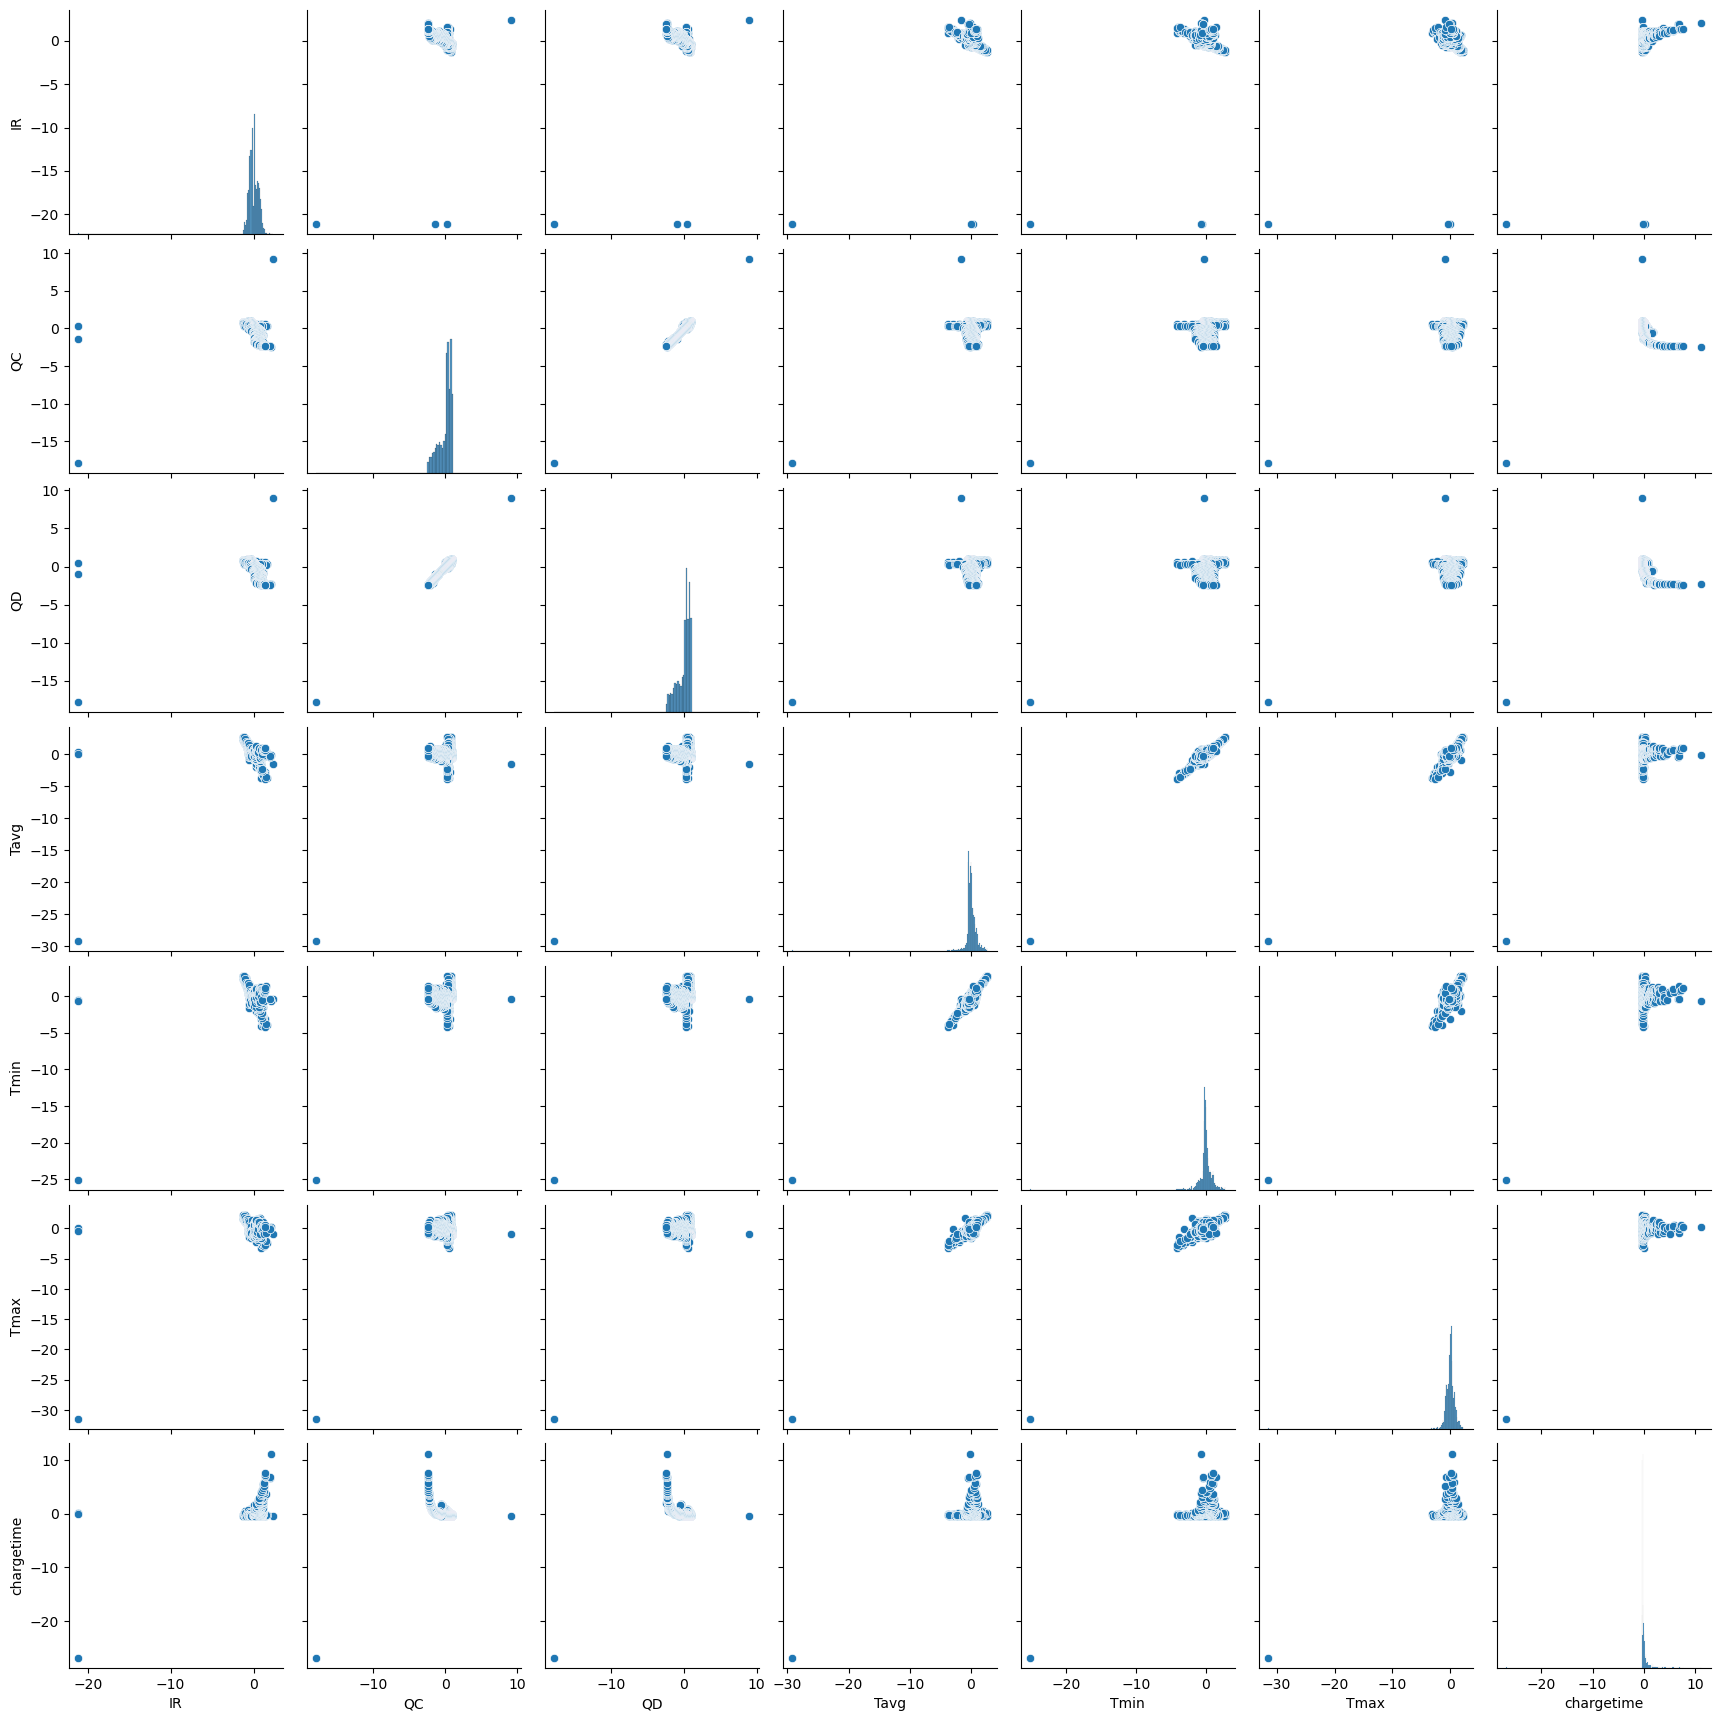

In [23]:
plt.figure(figsize=(10,8))

# Standardize the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Generate the pair plot (scatter plot matrix)
sns.pairplot(df_scaled)
plt.show()

### Random Forest implementation

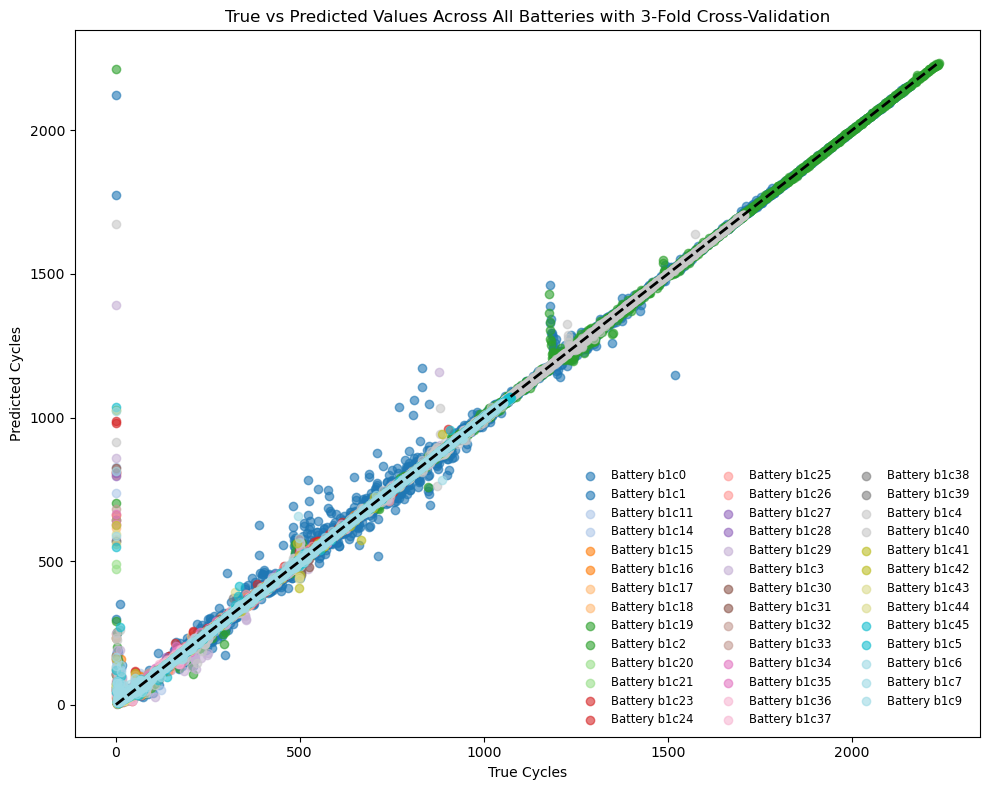

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize lists to store the metrics and predictions
mse_list = []
r2_list = []
battery_names = []

# Lists to store all true and predicted values across all batteries and folds
all_y_test = []
all_y_pred = []
all_battery_ids = []

# Number of folds for cross-validation
k = 3

# Iterate over each battery in batch1
for battery_key in batch1.keys():
    battery_summary_df = pd.DataFrame(batch1[battery_key]['summary'])
    features = battery_summary_df.iloc[:, :-1]
    target = battery_summary_df.iloc[:, -1]

    # Check if there is enough data to perform K-fold cross-validation
    if len(features) < k:
        print(f"Not enough data for battery {battery_key} to perform {k}-fold cross-validation. Skipping...")
        continue

    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Lists to store metrics for each fold
    fold_mse = []
    fold_r2 = []

    # Lists to store true and predicted values for each fold
    battery_y_test = []
    battery_y_pred = []

    # Perform K-fold cross-validation
    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_regressor.fit(X_train, y_train)
        y_pred = rf_regressor.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store metrics for this fold
        fold_mse.append(mse)
        fold_r2.append(r2)

        # Store true and predicted values
        battery_y_test.extend(y_test)
        battery_y_pred.extend(y_pred)

    # Compute average metrics across folds for this battery
    avg_mse = np.mean(fold_mse)
    avg_r2 = np.mean(fold_r2)

    # Store the average metrics
    mse_list.append(avg_mse)
    r2_list.append(avg_r2)
    battery_names.append(battery_key)

    # Store the true and predicted values along with battery ID
    all_y_test.extend(battery_y_test)
    all_y_pred.extend(battery_y_pred)
    all_battery_ids.extend([battery_key] * len(battery_y_test))

# Convert lists to numpy arrays for plotting
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
all_battery_ids = np.array(all_battery_ids)

# Create a color map for batteries
unique_batteries = np.unique(all_battery_ids)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_batteries)))
color_map = dict(zip(unique_batteries, colors))

# Plotting
plt.figure(figsize=(10, 8))
for battery in unique_batteries:
    idx = all_battery_ids == battery
    plt.scatter(
        all_y_test[idx],
        all_y_pred[idx],
        alpha=0.6,
        label=f'Battery {battery}',
        color=color_map[battery]
    )

# Plot the ideal line
min_val = min(all_y_test.min(), all_y_pred.min())
max_val = max(all_y_test.max(), all_y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.xlabel('True Cycles')
plt.ylabel('Predicted Cycles')
plt.title('True vs Predicted Values Across All Batteries with 3-Fold Cross-Validation')

# Adjust the legend
plt.legend(
    fontsize='smaller',
    loc='lower right',
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()


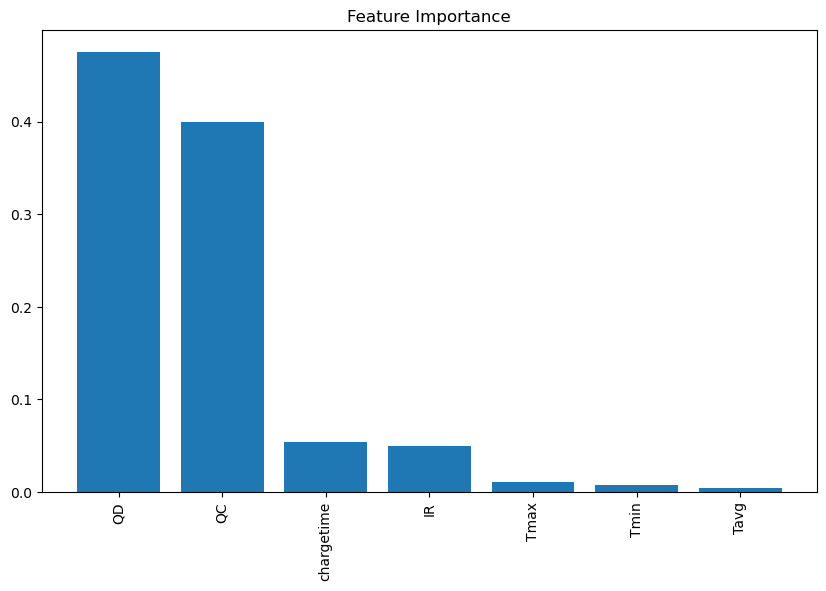

In [25]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(features.shape[1]), importances[indices], align="center")
plt.xticks(range(features.shape[1]), features.columns[indices], rotation=90)
plt.show()


In [26]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_regressor, features, target, cv=5, scoring='r2')

# Print the cross-validation R-squared scores
print("Cross-Validation R-squared Scores:", cv_scores)
print("Mean R-squared Score:", np.mean(cv_scores))


Cross-Validation R-squared Scores: [ -5.29730607   0.60131287  -0.30100859  -0.04938771 -14.72343784]
Mean R-squared Score: -3.9539654670851667


### LSTM implementation

In [27]:
# Initialize lists to store the metrics and predictions
mse_list = []
r2_list = []
battery_names = []

# Lists to store all true and predicted values across all batteries and folds
all_y_test = []
all_y_pred = []
all_battery_ids = []

# Number of folds for cross-validation
k = 3

# Iterate over each battery in batch1
for battery_key in batch1.keys():
    battery_summary_df = pd.DataFrame(batch1[battery_key]['summary'])

    # Assuming 'time' is a column representing the sequence order
    # and that the data is sorted by 'time'
    # If not, sort the data
    # battery_summary_df = battery_summary_df.sort_values('time')

    features = battery_summary_df.iloc[:, :-1].values  # Convert to NumPy array
    target = battery_summary_df.iloc[:, -1].values     # Convert to NumPy array

    # Check if there is enough data to perform K-fold cross-validation
    if len(features) < k:
        print(f"Not enough data for battery {battery_key} to perform {k}-fold cross-validation. Skipping...")
        continue

    # Reshape features for LSTM: (samples, timesteps, features)
    # Here, we'll assume timesteps = 1 (since we have tabular data)
    # If you have sequences, adjust timesteps accordingly
    features = features.reshape((features.shape[0], 1, features.shape[1]))

    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Lists to store metrics for each fold
    fold_mse = []
    fold_r2 = []

    # Lists to store true and predicted values for each fold
    battery_y_test = []
    battery_y_pred = []

    # Perform K-fold cross-validation
    fold = 1
    for train_index, test_index in kf.split(features):
        print(f"Battery {battery_key}, Fold {fold}")

        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = target[train_index], target[test_index]

        # Define the LSTM model
        model = Sequential()
        model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
        model.add(Dense(1))  # Output layer for regression
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=16,
            validation_data=(X_test, y_test),
            verbose=0  # Set to 1 to see training progress
        )

        # Predict on the test set
        y_pred = model.predict(X_test).flatten()

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store metrics for this fold
        fold_mse.append(mse)
        fold_r2.append(r2)

        # Store true and predicted values
        battery_y_test.extend(y_test)
        battery_y_pred.extend(y_pred)

        fold += 1

    # Compute average metrics across folds for this battery
    avg_mse = np.mean(fold_mse)
    avg_r2 = np.mean(fold_r2)

    # Store the average metrics
    mse_list.append(avg_mse)
    r2_list.append(avg_r2)
    battery_names.append(battery_key)

    # Store the true and predicted values along with battery ID
    all_y_test.extend(battery_y_test)
    all_y_pred.extend(battery_y_pred)
    all_battery_ids.extend([battery_key] * len(battery_y_test))

# Convert lists to numpy arrays for plotting
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
all_battery_ids = np.array(all_battery_ids)

# Create a color map for batteries
unique_batteries = np.unique(all_battery_ids)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_batteries)))
color_map = dict(zip(unique_batteries, colors))

# Plotting
plt.figure(figsize=(10, 8))
for battery in unique_batteries:
    idx = all_battery_ids == battery
    plt.scatter(
        all_y_test[idx],
        all_y_pred[idx],
        alpha=0.6,
        label=f'Battery {battery}',
        color=color_map[battery]
    )

# Plot the ideal line
min_val = min(all_y_test.min(), all_y_pred.min())
max_val = max(all_y_test.max(), all_y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.xlabel('True Cycles')
plt.ylabel('Predicted Cycles')
plt.title('True vs Predicted Values Across All Batteries with 3-Fold Cross-Validation (LSTM)')

# Adjust the legend
plt.legend(
    fontsize='smaller',
    loc='lower right',
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()


Battery b1c0, Fold 1


NameError: name 'Sequential' is not defined